In [ ]:
pip install -r requirements.txt

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.python.framework import ops
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from numpy.random import seed
from numpy.random import randint
from sklearn.utils import shuffle
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from tqdm import tqdm
import cv2
import os
import sys
import imutils
import random
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Image preprocessing ###

The original images contain black backgrounds of various sizes. Feeding these raw images into our model would result in lower accuracy because the model could pickup on background size as a feature for determining tumor type. To combat this, we can crop the images using the cv2 library. 

Below is an example of how we crop images from start to finish, as outlined in crop_image(img).

|Step 0 ) Original Image      |Step 1) Thresh Image                 |Step 2) Erode Image            | Step 3) Dilate Image         |Step 4) Crop Original Image |
|-----------------------------|-------------------------------------|-------------------------------|------------------------------|----------------------------|
| ![org](./utils/original.jpg)  |![thr](./utils/after_thresholding.jpg) |![ero](./utils/after_eroding.jpg)|![dil](./utils/after_dilate.jpg)|![cro](./utils/after_crop.jpg)|





In [2]:
def process_image(img,size):
    grayscale_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    _,thresholded_image = cv2.threshold(grayscale_image, 10, 255, cv2.THRESH_BINARY)
    eroded_image = cv2.erode(thresholded_image, None, iterations=2)
    dilated_image = cv2.dilate(eroded_image, None, iterations=2)
    
    contours = cv2.findContours(dilated_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    points = max(contours, key=cv2.contourArea) # [[[x_val,y_valval]]]
    
    x_points = []
    y_points = []
    for point in points:
        x_points.append(point[0][0])
        y_points.append(point[0][1])

    left = min(x_points)
    right = max(x_points)
    top = min(y_points)
    bottom = max(y_points)

    cropped_image = img[top:bottom, left:right]
    resized_image = cv2.resize(cropped_image,(size,size))
    
    return resized_image

#### Running the code block below will call the crop_image(img) method on all images in the data folder.

Note: This only needs to be run once to generate all the processed data, duplicate runs will overwrite.

The processed images will be in a new folder named `processed_data`

In [3]:
training = sys.path[0]+"/data/Training"
testing = sys.path[0]+"/data/Testing"

IMAGE_SIZE = 256

for directory in os.listdir(training):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
    new_folder = sys.path[0]+"/processed_data/Training/"+directory
    current_dir = training+"/"+directory
    
    if not(os.path.exists(new_folder)):
        os.makedirs(new_folder)
        
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        processed_image = process_image(image,IMAGE_SIZE)
        cv2.imwrite(new_folder+'/'+file, processed_image)


for directory in os.listdir(testing):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
    new_folder = sys.path[0]+"/processed_data/Testing/"+directory
    current_dir = testing+"/"+directory
    
    if not(os.path.exists(new_folder)):
        os.makedirs(new_folder)
        
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        processed_image = process_image(image,IMAGE_SIZE)
        cv2.imwrite(new_folder+'/'+file, processed_image)

## Mapping the data 

Our model is going to differentiate between 3  types of brain tumors: meningioma, pituitary, and glioma. Additionally, it is also possible for the patient to have no tumor at all.


The resulting output of our model will be a 4 dimensional vector v.

$$\begin{bmatrix} 1  \\ 0 \\ 0 \\ 0 \end{bmatrix}$$

The first value represents `notumor`, the second represents `glioma`, the third `meningioma` and the final value representing `pituitary`.

The cell below will prepare the training data and also add the corresponding labels for each image.

## Preparing the training data


In [4]:
x_train=[]
y_train=[]
training=sys.path[0]+"/processed_data/Training"
classes = ["notumor", "glioma", "meningioma", "pituitary"]

for directory in os.listdir(training):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
        
    current_dir = training+"/"+directory
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        x_train.append(image)
        
        y_val = np.zeros(4,dtype=int)
        y_val[classes.index(directory)] = 1
        y_train.append(y_val)

x_train = np.array(x_train) / 255
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(5712, 256, 256, 3)
(5712, 4)


### Sample training data

The cell below will show 12 randomly selected images from our prepared training set and the corresponding label for that image will be set in the x-axis

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


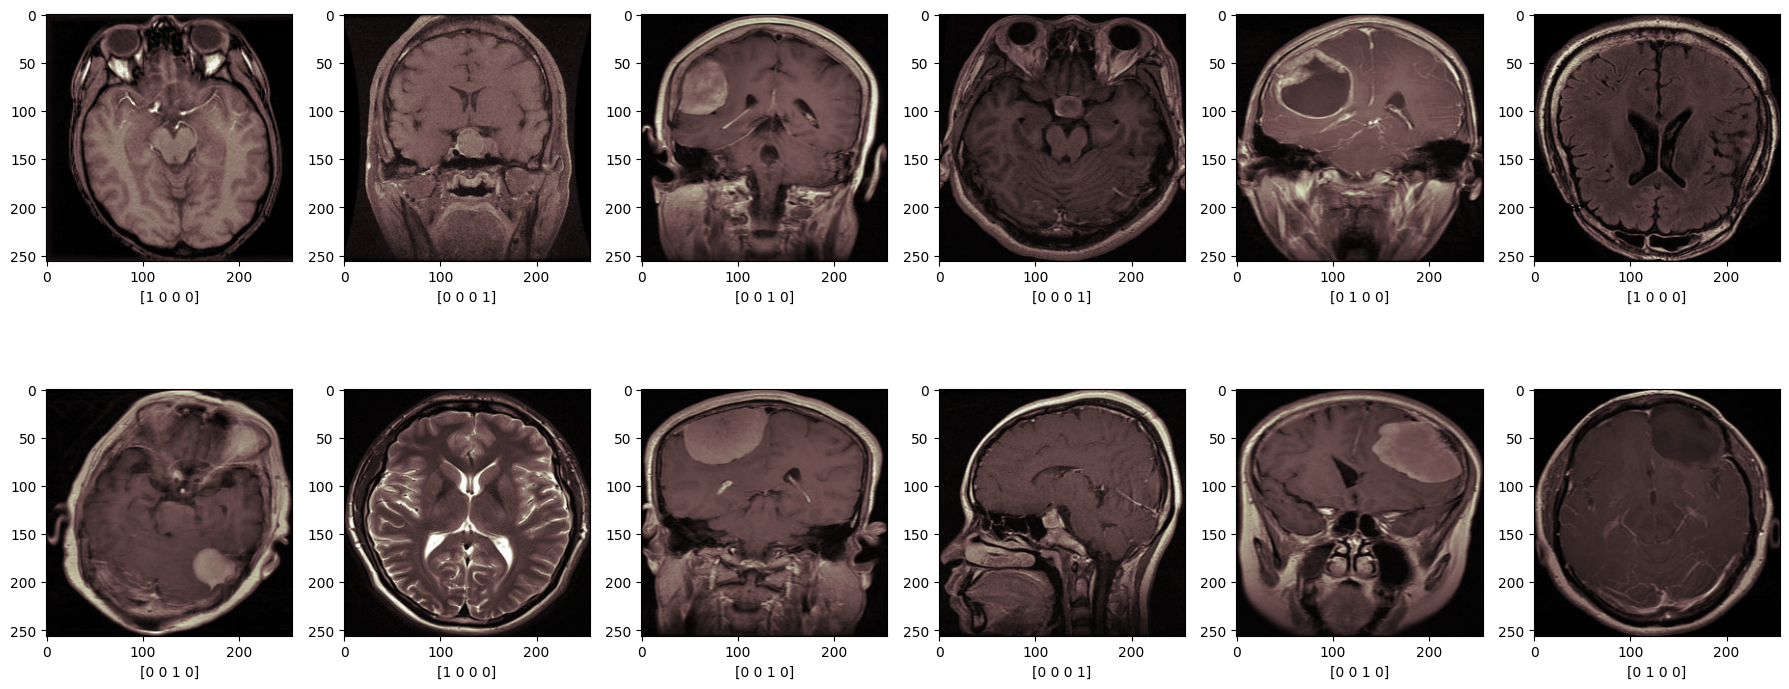

In [5]:
images = []
labels = []

random_indices = randint(0, x_train.shape[0], 12)
for index in random_indices:
    images.append(x_train[index])
    labels.append(y_train[index])

fig, axes = plt.subplots(2, 6, figsize = (18, 8))
axes2 = axes
axes = axes.flatten()

for img,label,axis in zip(images,labels,axes):
    axis.imshow(img)
    axis.set_xlabel(label)

plt.tight_layout()
plt.show()

## Preparing the testing data

The same process is done for the testing data that was done for the training data above.

There are also a few example images with their corresponding labels shown in the following cells.

In [6]:
x_test=[]
y_test=[]
testing=sys.path[0]+"/processed_data/Testing"
classes = ["notumor", "glioma", "meningioma", "pituitary"]

for directory in os.listdir(testing):
    if os.path.isfile(directory) or ".DS" in directory:
        continue
        
    current_dir = testing+"/"+directory
    for file in os.listdir(current_dir):
        if(file[0] =="."):
            continue
        image = cv2.imread(current_dir+"/"+file)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        x_test.append(image)
        
        y_val = np.zeros(4,dtype=int)
        y_val[classes.index(directory)] = 1
        y_test.append(y_val)

x_test = np.array(x_test) / 255
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)

(1311, 256, 256, 3)
(1311, 4)


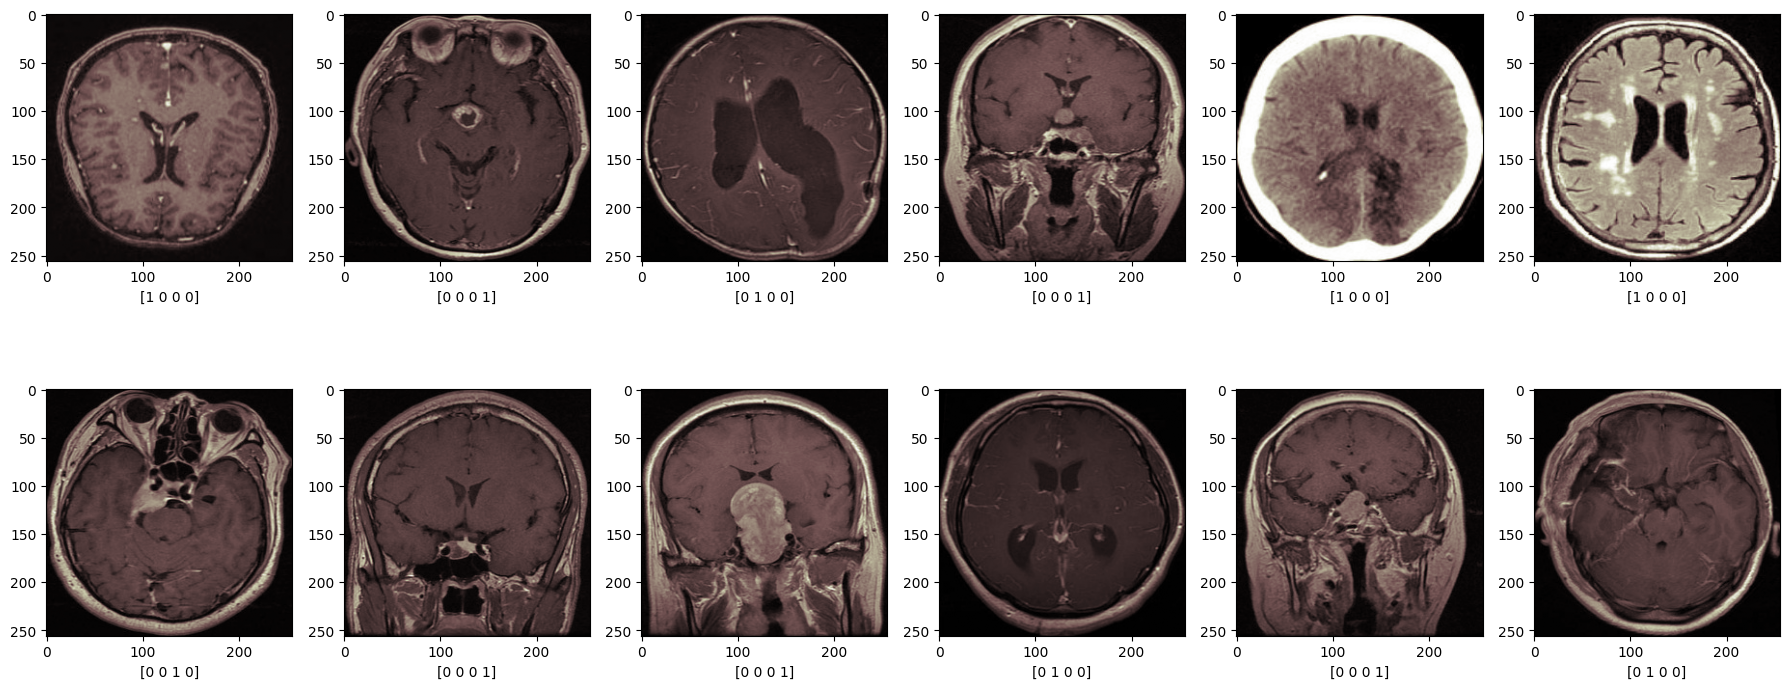

In [7]:
images = []
labels = []

random_indices = randint(0, x_test.shape[0], 12)
for index in random_indices:
    images.append(x_test[index])
    labels.append(y_test[index])

fig, axes = plt.subplots(2, 6, figsize = (18, 8))
axes2 = axes
axes = axes.flatten()

for img,label,axis in zip(images,labels,axes):
    axis.imshow(img)
    axis.set_xlabel(label)

plt.tight_layout()
plt.show()

### Artificial Image generation

Because we have a small dataset (~5700 images total), we need to generate artificial data by transforming the original data through a series of random translations and other image modifications.

For this we can use **tf.keras.preprocessing.image.ImageDataGenerator**.

The model was tested without the use of artificial image generation first, and had sub 50% accuracy on test sets.


In [14]:
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(x_train)

# Building the Model





In [19]:
base_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
)

In [ ]:
model = base_resnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
predictions = Dense(4, activation="softmax")(model)
model = Model(inputs= base_resnet.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

### Training the model

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10
history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), batch_size=BATCH_SIZE, shuffle=True, epochs=EPOCHS, verbose=2)

Epoch 1/10


2022-09-14 15:29:42.774494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


179/179 - 114s - loss: 0.5981 - accuracy: 0.7925 - 114s/epoch - 637ms/step
Epoch 2/10
179/179 - 101s - loss: 0.3199 - accuracy: 0.8841 - 101s/epoch - 566ms/step
Epoch 3/10
179/179 - 101s - loss: 0.2375 - accuracy: 0.9165 - 101s/epoch - 564ms/step
Epoch 4/10
179/179 - 101s - loss: 0.2028 - accuracy: 0.9280 - 101s/epoch - 564ms/step
Epoch 5/10
179/179 - 101s - loss: 0.1868 - accuracy: 0.9342 - 101s/epoch - 566ms/step
Epoch 6/10
179/179 - 101s - loss: 0.1676 - accuracy: 0.9421 - 101s/epoch - 563ms/step
Epoch 7/10


In [ ]:
test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

### References 
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download

https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

https://docs.opencv.org/4.x/
                    
https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

https://www.tensorflow.org/tutorials/images/transfer_learning

https://keras.io/api/applications/#usage-examples-for-image-classification-models

https://www.mayoclinic.org/diseases-conditions/pituitary-tumors/symptoms-causes/syc-20350548

https://www.mayoclinic.org/diseases-conditions/meningioma/symptoms-causes/syc-20355643

https://www.mayoclinic.org/diseases-conditions/glioma/symptoms-causes/syc-20350251